In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


# Step 1: Prepare the data

In [3]:
#Read the training data
with open('goblet_book.txt', 'r', encoding='utf-8') as f:
    book_data = f.read()

#Get unique characters
book_chars = sorted(list(set(book_data)))
K = len(book_chars)

#Create mappings from character to index and vice versa
char_to_ind = {ch: i for i, ch in enumerate(book_chars)}
ind_to_char = {i: ch for i, ch in enumerate(book_chars)}

# Step 2: Initialize the RNN's parameters

In [4]:
# Hyper-parameters
m = 100  # Dimension of hidden state
eta = 0.1  # learning rate
seq_length = 25  # length of input sequences

# Initialize the RNN Parameters
np.random.seed(42)
sig = 0.01
RNN = {
    'U': np.random.randn(m, K) * sig,
    'W': np.random.randn(m, m) * sig,
    'V': np.random.randn(K, m) * sig,
    'b': np.zeros((m, 1)),  # bias vector, mx1
    'c': np.zeros((K, 1))   # bias vector Kx1
}

# Step 3: Synthesize Text
We create a function to synthesize text from the RNN using the current parameter values.

h0 : hidden state at time 0
x0: the first (dummy) input vector to the RNN
n: the length of the sequence to generate

In [5]:
def synthesize_text(RNN, h0, x0, n):
    U, W, V, b, c = RNN['U'], RNN['W'], RNN['V'], RNN['b'], RNN['c']
    h = h0
    x = x0
    generated_text = []

    for t in range(n):
        a = np.dot(W, h) + np.dot(U, x) + b
        h = np.tanh(a)
        o = np.dot(V, h) + c
        p = np.exp(o) / np.sum(np.exp(o))

        # Sample the next character
        ix = np.random.choice(range(K), p=p.ravel())
        x = np.zeros((K,1))
        x[ix] = 1
        generated_text.append(ind_to_char[ix])
    return ''.join(generated_text)

# Step 4: Forward and Backward pass 

In [6]:
def forward(RNN, X, Y, h0):
    U, W, V, b, c = RNN['U'], RNN['W'], RNN['V'], RNN['b'], RNN['c']
    seq_length = X.shape[1]
    a, h, o, p = {}, {}, {}, {}
    h[-1] = h0
    loss = 0

    for t in range(seq_length):
        x = X[:, t].reshape(-1, 1)
        a[t] = np.dot(W, h[t-1]) + np.dot(U, x) + b
        h[t] = np.tanh(a[t])
        o[t] = np.dot(V, h[t]) + c
        p[t] = np.exp(o[t]) / np.sum(np.exp(o[t]))

        # Loss calculation based on Y
        loss += -np.log(p[t][np.argmax(Y[:, t])])

    return loss, a, h, o, p


In [7]:
def backward(RNN, X, Y, a, h, p):
    U, W, V, b, c = RNN['U'], RNN['W'], RNN['V'], RNN['b'], RNN['c']
    grads = {k: np.zeros_like(v) for k, v in RNN.items()}
    dh_next = np.zeros_like(h[0])

    for t in reversed(range(seq_length)):
        x = X[:, t].reshape(-1, 1)
        dy = p[t]
        dy[np.argmax(Y[:, t])] -= 1

        grads['V'] += np.dot(dy, h[t].T)
        grads['c'] += dy
        dh = np.dot(V.T, dy) + dh_next
        da = dh * (1 - h[t]**2)
        grads['b'] += da
        grads['W'] += np.dot(da, h[t-1].T)
        grads['U'] += np.dot(da, x.T)
        dh_next = np.dot(W.T, da)

    return grads

# Step 5: Implement AdaGrad
Implement the AdaGrad optimization algorithm to update the RNN parameters.



In [8]:
def adagrad_update(RNN, grads, mem, eta):
    for k in RNN.keys():
        mem[k] += grads[k] ** 2
        RNN[k] -= eta * grads[k] / (np.sqrt(mem[k]) + 1e-8)
    return RNN, mem

# Step 5a: Checking analytic gradient computation

In [9]:
def compute_loss(RNN, X, Y, h0):
    loss, _, _, _, _ = forward(RNN, X, Y, h0)
    return loss

def numerical_gradient(RNN, X, Y, h0, epsilon=1e-4):
    grads = {k: np.zeros_like(v) for k, v in RNN.items()}
    for param in RNN:
        for i in range(RNN[param].shape[0]):
            for j in range(RNN[param].shape[1]):
                original_value = RNN[param][i, j]
                RNN[param][i, j] = original_value + epsilon
                loss_plus = compute_loss(RNN, X, Y, h0)
                RNN[param][i, j] = original_value - epsilon
                loss_minus = compute_loss(RNN, X, Y, h0)
                RNN[param][i, j] = original_value
                grads[param][i, j] = (loss_plus - loss_minus) / (2 * epsilon)
    return grads

def relative_error(grad1, grad2):
    return np.sum(np.abs(grad1 - grad2)) / (np.sum(np.abs(grad1)) + np.sum(np.abs(grad2)))

# Set up initial conditions for gradient checking
h0 = np.zeros((m, 1))
X_chars = book_data[:seq_length]
Y_chars = book_data[1:seq_length + 1]
X = np.zeros((K, seq_length))
Y = np.zeros((K, seq_length))

for t in range(seq_length):
    X[char_to_ind[X_chars[t]], t] = 1
    Y[char_to_ind[Y_chars[t]], t] = 1

# Compute analytical gradients
_, a, h, o, p = forward(RNN, X, Y, h0)
analytical_grads = backward(RNN, X, Y, a, h, p)

# Compute numerical gradients
numerical_grads = numerical_gradient(RNN, X, Y, h0)

# Compare gradients and compute relative errors
for param in RNN:
    err = relative_error(numerical_grads[param], analytical_grads[param])
    print(f'Relative error for {param}: {err}')


Relative error for U: 3.3587074158724494e-09
Relative error for W: 1.0181149476062496e-07
Relative error for V: 1.7639763149180844e-08
Relative error for b: 1.8526463437329464e-09
Relative error for c: 4.745617095693915e-10


# Plotting smooth loss

## Modified Training Loop with Smooth Loss Tracking

Iteration 0, Smooth Loss: [109.55066684]
0Nu3W}aLgoZsSozP^Xmn embh Nnx:ZlkX
emdlK•iZxvmXQD;UT7wWQM"uBaX^R2ATjM6)^L.e6TBx9LzCZC,avNY^Ia?HLsEb79^lMDu.dfaxeAFI w(ferTiAiEv2CPlh4/BNWKdKy?aW;IG2QH1LL..Zgx)-"QaHobü/"A
wBRC;0B^}YR!n!uV2N•BA-U)hwx,T
Iteration 1000, Smooth Loss: [85.52591309]
aoognr..
	Hthirmiind.
	the ceds, litaleghactl the thi t be mey.. d sgokva lth..k	Asthy morot.
	has  hogle arescf bonl.  bivhog che tuing thlcg.g Bickesktit..urt the dslthtgacy b ctelter.t soce anwed a
Iteration 2000, Smooth Loss: [70.58760352]
gutd, pot ueethain inoemapeel to pl htiti- snarroigtres aicrigno?'s." Isse the ing woutiid hiweiofsedos, scounithy, oo"mis ouwps the te ensen caoofow "ofeith  beited  ugd lr iarllet, pn?" bocluldfof r
Iteration 3000, Smooth Loss: [62.60225172]
ngereny reat and aed linco areane yenting rathl thing.
AOllang uncand Bridevtrog his ind aveime We kit ;sB aslerit sald, erlomailing ontenlund bouglp irricancarlud souvling coar ir imputsile iog illin
Iteration 4000, Smooth Los

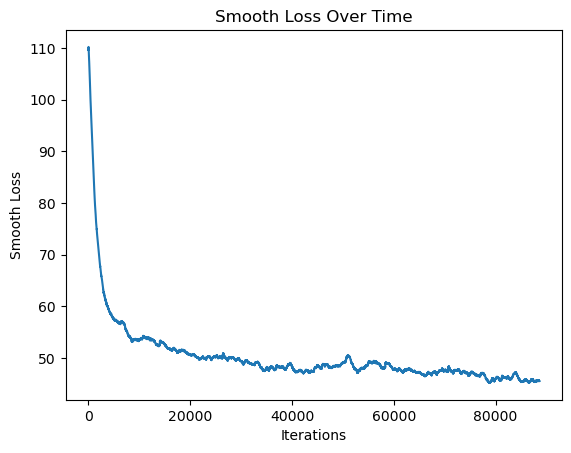

Best Passage (1000 characters):
him Halmentwouldestinstering iom Sume, the wasting firy dising had go aid Horry sort derite.  Pired vom tal himent, spilling oane loons on a come that hid at you not I sexertermed it Harry's you himply ithe.  "I it of becaid avem mond,"  a sime.  Ot boonghtake it?"
He notwing onaring but tod"b in uss,"  an whol.
Harry Harry, stinss yay it couber neeplides. Whoughhed us reglly fave in.  Ably starround Lithail turay.  He spoone visaulowor woline no would what whick were eane, goan.  "You ool aglte . . . Trofed, Coilked theated Magie.  Harry whow, whoked.  The of expere willer it Mare the hic ow readle the waza vill rieved thet remer, Enatlod."
Dixhat, Harryenped afing whidn wouldme Fnitill.  I mored then waath will extrover, wink, to?"
Me wor corly rosto."
You adpent them, it his foughly gote Bowney nawhe hading tlestr hymunnt roce to thing Harry yougn to dooksing gaty the Dorsily Sigh to mived ked air. 
"Whoughenf toine was Penping up most wain. "Youverul

In [10]:
import matplotlib.pyplot as plt

# Initialize memory for AdaGrad
mem = {k: np.zeros_like(v) for k, v in RNN.items()}

# Calculate the number of iterations per epoch
iterations_per_epoch = len(book_data) // seq_length
n_updates = 2 * iterations_per_epoch  # Number of updates to cover at least 2 epochs

# Training loop
smooth_loss = -np.log(1.0 / K) * seq_length  # Initialize smooth loss
losses = []  # To store smooth loss values
synthesized_texts = []  # To store synthesized texts
best_model = None
best_loss = float('inf')

e = 0  # Initialize data pointer
hprev = np.zeros((m, 1))  # Initialize hidden state

for update in range(n_updates):
    if e + seq_length + 1 >= len(book_data):
        e = 0
        hprev = np.zeros((m, 1))

    # Prepare inputs and targets
    X_chars = book_data[e:e + seq_length]
    Y_chars = book_data[e + 1:e + seq_length + 1]
    X = np.zeros((K, seq_length))
    Y = np.zeros((K, seq_length))

    for t in range(seq_length):
        X[char_to_ind[X_chars[t]], t] = 1
        Y[char_to_ind[Y_chars[t]], t] = 1

    # Forward and backward pass
    loss, a, h, o, p = forward(RNN, X, Y, hprev)
    grads = backward(RNN, X, Y, a, h, p)

    # Clip gradients
    for grad in grads.values():
        np.clip(grad, -5, 5, out=grad)

    # Update parameters with AdaGrad
    RNN, mem = adagrad_update(RNN, grads, mem, eta)

    # Update smooth loss
    smooth_loss = 0.999 * smooth_loss + 0.001 * loss
    losses.append(smooth_loss)

    # Track the best model
    if smooth_loss < best_loss:
        best_loss = smooth_loss
        best_model = {k: v.copy() for k, v in RNN.items()}

    # Print loss and sample text every 1000 iterations
    if update % 1000 == 0:
        print(f'Iteration {update}, Smooth Loss: {smooth_loss}')
        sample_text = synthesize_text(RNN, hprev, X[:, 0].reshape(-1, 1), 200)
        print(sample_text)
        if update % 10000 == 0:
            synthesized_texts.append((update, sample_text))

    # Move data pointer
    e += seq_length

# Plot the smooth loss
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Smooth Loss')
plt.title('Smooth Loss Over Time')
plt.show()

# Generate a passage from the best model
best_hprev = np.zeros((m, 1))  # Initialize hidden state for best model
best_x0 = np.zeros((K, 1))  # Initial input for best model (e.g., start with space or any character)
best_x0[char_to_ind[' ']] = 1  # Starting with a space
best_passage = synthesize_text(best_model, best_hprev, best_x0, 1000)
print(f'Best Passage (1000 characters):\n{best_passage}')


# Text Synthesis at Intervals

## Modified Training Loop for Text Synthesis

Iteration 0, Smooth Loss: [109.54407259]
ARRT RET TE T EERTTEEEERRE ARNE  NRERHRE    RT ETRETNTREE R HE  TERLERREENTTEE EERR TEER DEEE RERR TE RN EERRREHE   EEE TRRE  TE  EE  RTNE  RT  TTEET REE EERE RTT ENTRTETETRETTRT YERE T T ETRE TEYRTTR
Iteration 1000, Smooth Loss: [82.59559491]
oraid...e, 	A co Puzl than woiggig, bste hole fond.e hong Haldimionhe Hurllily.h.oto mion ing....uhl,.ed wolited, milttololle houd hetere pos coltc	ome cege punh Heistilocn Vevicd Hasev the wtt thad.e
Iteration 2000, Smooth Loss: [68.7089931]
pornigle Dodiow pum nily laf in vibn sowe, ,""t sat thecus get thend han retoucou yean the thid't Hicg ineket?" our to she His ank trich co gntas."a loud Dus  Hitos wonk pulret rahe waige witipst.le p
Iteration 3000, Smooth Loss: [62.11949695]
ghiaet aut auf bofl
Hadrvlile sexpyand wamey thon rorn't Wean; Bnoug arwas  fornting oudy, yoinol Ver sto, un torts hadd t-"asherast ung talls Bund nou sundublerefly houllapole, on on, intudd'lliram p
Iteration 4000, Smooth Loss

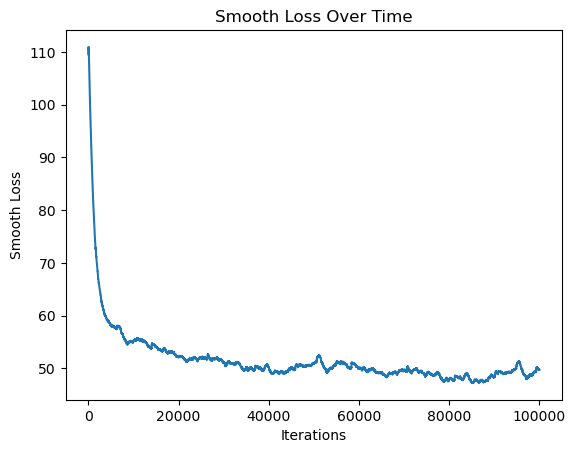

Best Passage (1000 characters):
Dumble . . Harrel fere Harry over, wask andfmegoughte bemoelve tool wistwes ceemes nos his never up; pacicast tive the said exand in the sondeanrostwablece had she wands mabentor Higst of that his he wan fremstamius Ron on Madus shing a record up.  I who more.  I Hoverespating spiol hod stow ung a on. . . Cup, Much to rope tiry doincat Mhoud . to plod stibuncted his at yaneloked over notastro, his toistac.  Ponnating seefferoull hing't der- and st," he word weise to "tofed a Dut, and - the boflise wo keem -"Bursn. . . Cow to an's the saalbied roban - Heilincted into doon his drastod Duchtred os afis out ho?"
"Whakunamis cound abaw tive "Unto he lave he said - itios - be of Muthind.  Ml. .". unduth a peed homing rasm. a Poohace they, hidevered, subandy on's -"
"Sine.  roles encon you nop was you ting furs hathe could 'ting plow stacee inis, Moods, firlind upming om Moo to do sorse he wasstold of Mound "Crawt" no? I bow him she omwas yead. s. . . oourse.
"

In [12]:
# Initialize memory for AdaGrad
mem = {k: np.zeros_like(v) for k, v in RNN.items()}

# Calculate the number of iterations per epoch
iterations_per_epoch = len(book_data) // seq_length
n_updates = 100000  # Number of updates to cover at least 2 epochs

# Training loop
smooth_loss = -np.log(1.0 / K) * seq_length  # Initialize smooth loss
losses = []  # To store smooth loss values
synthesized_texts = []  # To store synthesized texts
best_model = None
best_loss = float('inf')

e = 0  # Initialize data pointer
hprev = np.zeros((m, 1))  # Initialize hidden state

# Initial synthesized text before training
initial_text = synthesize_text(RNN, hprev, np.zeros((K, 1)), 200)
print(f"Initial Text before training: {initial_text}")
synthesized_texts.append((0, initial_text))

for update in range(n_updates):
    if e + seq_length + 1 >= len(book_data):
        e = 0
        hprev = np.zeros((m, 1))

    # Prepare inputs and targets
    X_chars = book_data[e:e + seq_length]
    Y_chars = book_data[e + 1:e + seq_length + 1]
    X = np.zeros((K, seq_length))
    Y = np.zeros((K, seq_length))

    for t in range(seq_length):
        X[char_to_ind[X_chars[t]], t] = 1
        Y[char_to_ind[Y_chars[t]], t] = 1

    # Forward and backward pass
    loss, a, h, o, p = forward(RNN, X, Y, hprev)
    grads = backward(RNN, X, Y, a, h, p)

    # Clip gradients
    for grad in grads.values():
        np.clip(grad, -5, 5, out=grad)

    # Update parameters with AdaGrad
    RNN, mem = adagrad_update(RNN, grads, mem, eta)

    # Update smooth loss
    smooth_loss = 0.999 * smooth_loss + 0.001 * loss
    losses.append(smooth_loss)

    # Track the best model
    if smooth_loss < best_loss:
        best_loss = smooth_loss
        best_model = {k: v.copy() for k, v in RNN.items()}

    # Print loss and sample text every 1000 iterations
    if update % 1000 == 0:
        print(f'Iteration {update}, Smooth Loss: {smooth_loss}')
        sample_text = synthesize_text(RNN, hprev, X[:, 0].reshape(-1, 1), 200)
        print(sample_text)
        if update % 10000 == 0:
            synthesized_texts.append((update, sample_text))

    # Move data pointer
    e += seq_length

# Plot the smooth loss
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Smooth Loss')
plt.title('Smooth Loss Over Time')
plt.show()

# Generate a passage from the best model
best_hprev = np.zeros((m, 1))  # Initialize hidden state for best model
best_x0 = np.zeros((K, 1))  # Initial input for best model (e.g., start with space or any character)
best_x0[char_to_ind[' ']] = 1  # Starting with a space
best_passage = synthesize_text(best_model, best_hprev, best_x0, 1000)
print(f'Best Passage (1000 characters):\n{best_passage}')

# Print synthesized texts at specified intervals
for step, text in synthesized_texts:
    print(f'\nSynthesized text at step {step}:\n{text}')